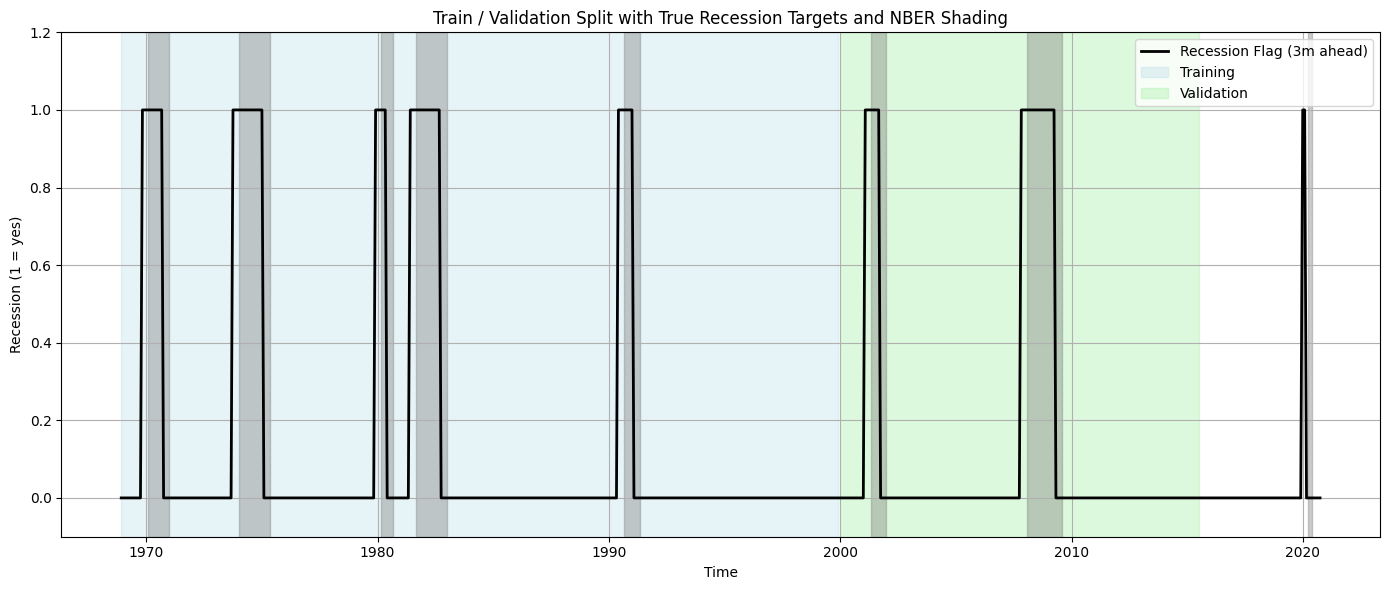

In [113]:
import matplotlib.pyplot as plt

# --------------- Load Data
features = pd.read_pickle("recession_features.pkl")
# Add the 'recession_flag_current' column (this was missing)
features["recession_flag_current"] = features["recession_flag_3m_ahead"].shift(3)
features = features.iloc[3:]  # because we shifted 3 months
target = features['recession_flag_3m_ahead']

# --------------- Define splits
n_total   = len(features)
train_end = int(n_total * 0.60)
val_end   = int(n_total * 0.90)

# --------------- Identify train/val/test indices
train_idx = features.index[:train_end]
val_idx   = features.index[train_end:val_end]
test_idx  = features.index[val_end:]

# --------------- Plot
plt.figure(figsize=(14,6))

# Plot true target (binary)
plt.plot(features.index, target, label='Recession Flag (3m ahead)', color='black', lw=2)

# Shade training set
plt.axvspan(train_idx[0], train_idx[-1], color='lightblue', alpha=0.3, label='Training')

# Shade validation set
plt.axvspan(val_idx[0], val_idx[-1], color='lightgreen', alpha=0.3, label='Validation')

# Shade NBER official recession periods (original, not shifted)
recession_flag_now = features['recession_flag_current']  # unshifted flag
starts = recession_flag_now[(recession_flag_now.diff() == 1)].index
ends   = recession_flag_now[(recession_flag_now.diff() == -1)].index

# If series starts during recession
if recession_flag_now.iloc[0] == 1:
    starts = starts.insert(0, recession_flag_now.index[0])

for start, end in zip(starts, ends):
    plt.axvspan(start, end, color='gray', alpha=0.4)

# Labels and formatting
plt.title('Train / Validation Split with True Recession Targets and NBER Shading')
plt.ylabel('Recession (1 = yes)')
plt.xlabel('Time')
plt.ylim(-0.1, 1.2)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [119]:
import pandas as pd
import numpy as np
import joblib, math, time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [120]:
class BiLSTM(nn.Module):
    def __init__(self, n_features, hidden):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden,
                            num_layers=1, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden*2, 32)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(32, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last = lstm_out[:, -1, :]
        x = self.drop(self.act(self.fc1(last)))
        return self.out(x).squeeze(1)

In [123]:
WINDOW   = 12          # look-back length (months)
BATCH    = 64
HIDDEN   = 64
EPOCHS   = 200
PATIENCE = 10
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"

features = pd.read_pickle("recession_features.pkl")

features["recession_flag_current"] = features["recession_flag_3m_ahead"].shift(3)

# drop first 3 rows created by shift
features = features.iloc[3:]

y = features["recession_flag_3m_ahead"].values.astype(np.float32)
X = features.drop(columns=["recession_flag_3m_ahead"]).values.astype(np.float32)

# ---------------------------------- 3. chronological 60-30-10 split (indices)
n_total   = len(features)
train_end = int(n_total * 0.60)
val_end   = int(n_total * 0.90)

# fit scaler only on train slice
scaler = StandardScaler()
X[:train_end] = scaler.fit_transform(X[:train_end])
X[train_end:] = scaler.transform(X[train_end:])
joblib.dump(scaler, "scaler_bilstm.joblib")

# ---------------------------------- 4. helper: build windowed tensors
def make_sequences(Xmat, yvec, start, end, window):
    seq_X, seq_y = [], []
    for i in range(start, end - window + 1):
        seq_X.append(Xmat[i : i + window])
        seq_y.append(yvec[i + window - 1])   # target at window end (already t+3)
    return torch.tensor(seq_X), torch.tensor(seq_y)

# training windows stay strictly inside training span
X_train_t, y_train_t = make_sequences(X, y, 0, train_end, WINDOW)
# validation windows start WINDOW months before val span so model has context
X_val_t,   y_val_t   = make_sequences(X, y, train_end-WINDOW, val_end, WINDOW)
# test windows start WINDOW months before test span (captures covid period)
X_test_t,  y_test_t  = make_sequences(X, y, val_end-WINDOW, n_total, WINDOW)

class SeqDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self):        return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(SeqDataset(X_train_t, y_train_t), batch_size=BATCH,
                          shuffle=False, drop_last=False)
val_loader   = DataLoader(SeqDataset(X_val_t,   y_val_t),   batch_size=BATCH,
                          shuffle=False)
test_loader  = DataLoader(SeqDataset(X_test_t,  y_test_t),  batch_size=BATCH,
                          shuffle=False)



model = BiLSTM(n_features=X_train_t.shape[2], hidden=HIDDEN).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.5e-3)



best_val_loss, patience_ctr = math.inf, 0
for epoch in range(1, EPOCHS+1):
    model.train(); train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward(); optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)

    model.eval(); val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            val_loss += criterion(model(xb), yb).item() * len(xb)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:3d} — train {train_loss:.4f}  val {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss, patience_ctr = val_loss, 0
        torch.save(model.state_dict(), "bilstm_best.pt")
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("Early stopping"); break

# load best
model.load_state_dict(torch.load("bilstm_best.pt"))



Epoch   1 — train 0.7558  val 0.7570
Epoch   2 — train 0.7338  val 0.7382
Epoch   3 — train 0.7144  val 0.7181
Epoch   4 — train 0.6955  val 0.6961
Epoch   5 — train 0.6723  val 0.6708
Epoch   6 — train 0.6428  val 0.6410
Epoch   7 — train 0.6081  val 0.6039
Epoch   8 — train 0.5653  val 0.5555
Epoch   9 — train 0.5129  val 0.4917
Epoch  10 — train 0.4385  val 0.4118
Epoch  11 — train 0.3557  val 0.3256
Epoch  12 — train 0.2839  val 0.2587
Epoch  13 — train 0.2273  val 0.2299
Epoch  14 — train 0.2014  val 0.2313
Epoch  15 — train 0.1709  val 0.2434
Epoch  16 — train 0.1550  val 0.2556
Epoch  17 — train 0.1323  val 0.2675
Epoch  18 — train 0.1237  val 0.2812
Epoch  19 — train 0.1115  val 0.2948
Epoch  20 — train 0.1073  val 0.3113
Epoch  21 — train 0.0959  val 0.3298
Epoch  22 — train 0.0898  val 0.3446
Epoch  23 — train 0.0857  val 0.3580
Early stopping


<All keys matched successfully>

In [124]:
def predict(loader):
    model.eval(); preds, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            preds.append(torch.sigmoid(model(xb.to(DEVICE))).cpu())
            ys.append(yb)
    return torch.cat(preds).numpy(), torch.cat(ys).numpy()

val_pred, val_true   = predict(val_loader)

print("Validation AUC  :", roc_auc_score(val_true,  val_pred))
print("Validation ACC  :", accuracy_score(val_true, val_pred > 0.5))

# ---------------------------------- 8. persist artefacts
torch.save(model.state_dict(), "bilstm_recession_pytorch.pt")

Validation AUC  : 0.9696106362773029
Validation ACC  : 0.8617021276595744


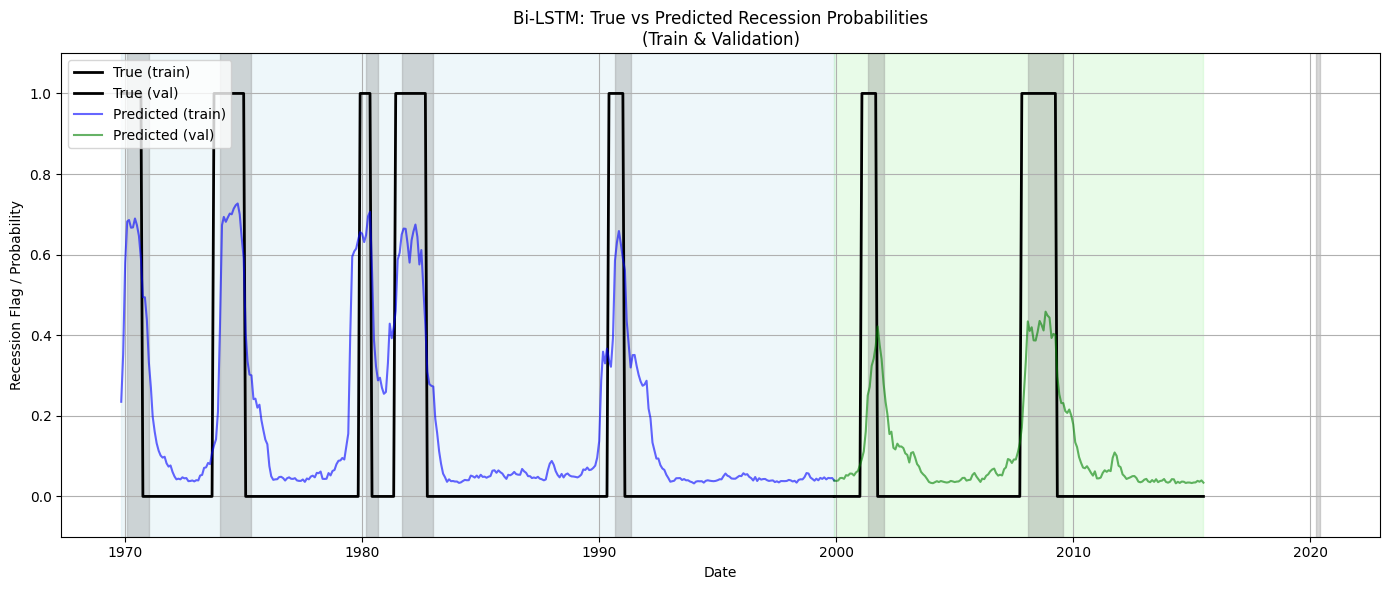

In [125]:
import matplotlib.pyplot as plt

# --- 1. Get predictions (reuse your helper)
train_pred, train_true = predict(train_loader)
val_pred,   val_true   = predict(val_loader)

# --- 2. Compute the correct datetime indices
#   For train: windows run from i=0..(train_end-WINDOW), ends at i+WINDOW-1 = WINDOW-1..train_end-1
train_idx = features.index[WINDOW-1 : train_end]

#   For validation: windows start at i=train_end-WINDOW..(val_end-WINDOW), ends at i+WINDOW-1 = train_end-1..val_end-1
val_idx = features.index[train_end-1 : val_end]

# --- 3. Plotting
plt.figure(figsize=(14,6))

# True flag (binary)
plt.plot(train_idx, train_true, color='black', lw=2, label='True (train)')
plt.plot(val_idx,   val_true,   color='black', lw=2, label='True (val)')

# Predicted probability
plt.plot(train_idx, train_pred, color='blue',  alpha=0.6, label='Predicted (train)')
plt.plot(val_idx,   val_pred,   color='green', alpha=0.6, label='Predicted (val)')

# Background shading for train/val spans
plt.axvspan(train_idx[0], train_idx[-1], color='lightblue',  alpha=0.2)
plt.axvspan(val_idx[0],   val_idx[-1],   color='lightgreen', alpha=0.2)

# Gray shading for official NBER recessions (unshifted flag)
rec = features['recession_flag_current']
starts = rec[rec.diff()==1].index
ends   = rec[rec.diff()==-1].index
if rec.iloc[0] == 1:
    starts = starts.insert(0, rec.index[0])
for s, e in zip(starts, ends):
    plt.axvspan(s, e, color='gray', alpha=0.3)

plt.title("Bi-LSTM: True vs Predicted Recession Probabilities\n(Train & Validation)")
plt.xlabel("Date")
plt.ylabel("Recession Flag / Probability")
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [151]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvancedBiLSTM(nn.Module):
    """
    Multi-layer bidirectional LSTM with layer normalization, self-attention, and two-stage classifier head.
    """
    def __init__(self, n_features, hidden, num_layers=3, dropout=0.15):
        super().__init__()
        self.hidden_dim = hidden
        self.num_layers = num_layers

        # Stacked bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # Layer normalization on LSTM outputs
        self.layer_norm = nn.LayerNorm(hidden * 2)

        # Self-attention mechanism
        self.attn_fc = nn.Linear(hidden * 2, 1)

        # Classification head
        self.fc1 = nn.Linear(hidden* 2, hidden)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden, 1)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, input_dim)
        returns: logits of shape (batch_size,)
        """
        # LSTM output: (batch, seq_len, 2*hidden_dim)
        out, _ = self.lstm(x)

        # Apply layer normalization
        out = self.layer_norm(out)

        # Compute attention scores and weights
        attn_scores = self.attn_fc(out)            # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # (batch, seq_len, 1)

        # Weighted sum to get context vector
        context = torch.sum(attn_weights * out, dim=1)    # (batch, 2*hidden_dim)

        # Classification head
        h = F.relu(self.fc1(context))
        h = self.dropout(h)
        logits = self.fc2(h).squeeze(1)                   # (batch,)

        return logits


In [153]:
WINDOW   = 12          # look-back length (months)
BATCH    = 32
HIDDEN   = 64
EPOCHS   = 200
PATIENCE = 10
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"

features = pd.read_pickle("recession_features.pkl")

features["recession_flag_current"] = features["recession_flag_3m_ahead"].shift(3)

# drop first 3 rows created by shift
features = features.iloc[3:]

y = features["recession_flag_3m_ahead"].values.astype(np.float32)
X = features.drop(columns=["recession_flag_3m_ahead"]).values.astype(np.float32)

# ---------------------------------- 3. chronological 60-30-10 split (indices)
n_total   = len(features)
train_end = int(n_total * 0.60)
val_end   = int(n_total * 0.90)

# fit scaler only on train slice
scaler = StandardScaler()
X[:train_end] = scaler.fit_transform(X[:train_end])
X[train_end:] = scaler.transform(X[train_end:])
joblib.dump(scaler, "scaler_bilstm.joblib")

# ---------------------------------- 4. helper: build windowed tensors
def make_sequences(Xmat, yvec, start, end, window):
    seq_X, seq_y = [], []
    for i in range(start, end - window + 1):
        seq_X.append(Xmat[i : i + window])
        seq_y.append(yvec[i + window - 1])   # target at window end (already t+3)
    return torch.tensor(seq_X), torch.tensor(seq_y)

# training windows stay strictly inside training span
X_train_t, y_train_t = make_sequences(X, y, 0, train_end, WINDOW)
# validation windows start WINDOW months before val span so model has context
X_val_t,   y_val_t   = make_sequences(X, y, train_end-WINDOW, val_end, WINDOW)
# test windows start WINDOW months before test span (captures covid period)
X_test_t,  y_test_t  = make_sequences(X, y, val_end-WINDOW, n_total, WINDOW)

class SeqDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self):        return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(SeqDataset(X_train_t, y_train_t), batch_size=BATCH,
                          shuffle=False, drop_last=False)
val_loader   = DataLoader(SeqDataset(X_val_t,   y_val_t),   batch_size=BATCH,
                          shuffle=False)
test_loader  = DataLoader(SeqDataset(X_test_t,  y_test_t),  batch_size=BATCH,
                          shuffle=False)



model = AdvancedBiLSTM(n_features=X_train_t.shape[2], hidden=HIDDEN).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.3e-3)



best_val_loss, patience_ctr = math.inf, 0
for epoch in range(1, EPOCHS+1):
    model.train(); train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward(); optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)

    model.eval(); val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            val_loss += criterion(model(xb), yb).item() * len(xb)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:3d} — train {train_loss:.4f}  val {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss, patience_ctr = val_loss, 0
        torch.save(model.state_dict(), "bilstm_best.pt")
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("Early stopping"); break

# load best
model.load_state_dict(torch.load("bilstm_best.pt"))



Epoch   1 — train 0.4997  val 0.4053
Epoch   2 — train 0.3800  val 0.3517
Epoch   3 — train 0.3250  val 0.3327
Epoch   4 — train 0.2610  val 0.3265
Epoch   5 — train 0.2214  val 0.3266
Epoch   6 — train 0.1841  val 0.3052
Epoch   7 — train 0.1543  val 0.2562
Epoch   8 — train 0.1218  val 0.2403
Epoch   9 — train 0.0949  val 0.2196
Epoch  10 — train 0.0687  val 0.2524
Epoch  11 — train 0.0585  val 0.2898
Epoch  12 — train 0.0440  val 0.3385
Epoch  13 — train 0.0415  val 0.3335
Epoch  14 — train 0.0457  val 0.3666
Epoch  15 — train 0.0345  val 0.3469
Epoch  16 — train 0.0330  val 0.4001
Epoch  17 — train 0.0284  val 0.2236
Epoch  18 — train 0.0380  val 0.4432
Epoch  19 — train 0.0366  val 0.1743
Epoch  20 — train 0.0362  val 0.4023
Epoch  21 — train 0.0191  val 0.2904
Epoch  22 — train 0.0142  val 0.2852
Epoch  23 — train 0.0127  val 0.2615
Epoch  24 — train 0.0126  val 0.2874
Epoch  25 — train 0.0070  val 0.2208
Epoch  26 — train 0.0080  val 0.3971
Epoch  27 — train 0.0110  val 0.3084
E

<All keys matched successfully>

In [154]:
def predict(loader):
    model.eval(); preds, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            preds.append(torch.sigmoid(model(xb.to(DEVICE))).cpu())
            ys.append(yb)
    return torch.cat(preds).numpy(), torch.cat(ys).numpy()

val_pred, val_true   = predict(val_loader)

print("Validation AUC  :", roc_auc_score(val_true,  val_pred))
print("Validation ACC  :", accuracy_score(val_true, val_pred > 0.5))

# ---------------------------------- 8. persist artefacts
torch.save(model.state_dict(), "bilstm_recession_pytorch.pt")

Validation AUC  : 0.9840930674264007
Validation ACC  : 0.9095744680851063


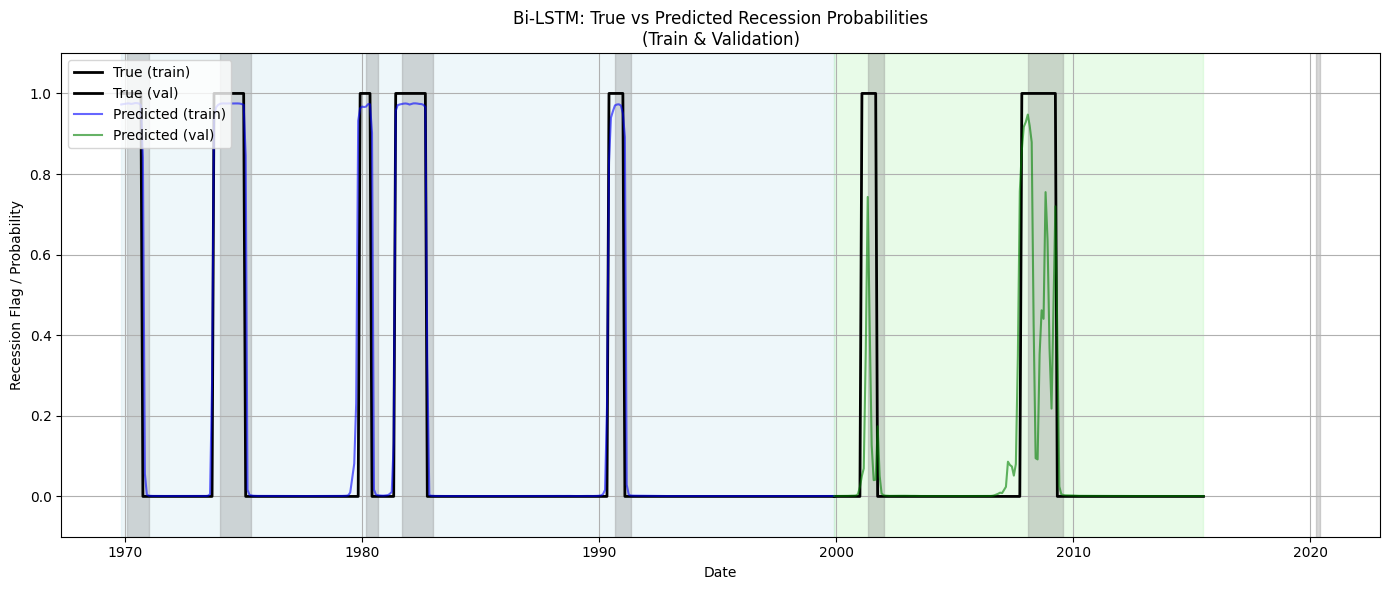

In [155]:
import matplotlib.pyplot as plt

# --- 1. Get predictions (reuse your helper)
train_pred, train_true = predict(train_loader)
val_pred,   val_true   = predict(val_loader)

# --- 2. Compute the correct datetime indices
#   For train: windows run from i=0..(train_end-WINDOW), ends at i+WINDOW-1 = WINDOW-1..train_end-1
train_idx = features.index[WINDOW-1 : train_end]

#   For validation: windows start at i=train_end-WINDOW..(val_end-WINDOW), ends at i+WINDOW-1 = train_end-1..val_end-1
val_idx = features.index[train_end-1 : val_end]

# --- 3. Plotting
plt.figure(figsize=(14,6))

# True flag (binary)
plt.plot(train_idx, train_true, color='black', lw=2, label='True (train)')
plt.plot(val_idx,   val_true,   color='black', lw=2, label='True (val)')

# Predicted probability
plt.plot(train_idx, train_pred, color='blue',  alpha=0.6, label='Predicted (train)')
plt.plot(val_idx,   val_pred,   color='green', alpha=0.6, label='Predicted (val)')

# Background shading for train/val spans
plt.axvspan(train_idx[0], train_idx[-1], color='lightblue',  alpha=0.2)
plt.axvspan(val_idx[0],   val_idx[-1],   color='lightgreen', alpha=0.2)

# Gray shading for official NBER recessions (unshifted flag)
rec = features['recession_flag_current']
starts = rec[rec.diff()==1].index
ends   = rec[rec.diff()==-1].index
if rec.iloc[0] == 1:
    starts = starts.insert(0, rec.index[0])
for s, e in zip(starts, ends):
    plt.axvspan(s, e, color='gray', alpha=0.3)

plt.title("Bi-LSTM: True vs Predicted Recession Probabilities\n(Train & Validation)")
plt.xlabel("Date")
plt.ylabel("Recession Flag / Probability")
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
